In [1]:
# --- 1. SETUP AND IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import warnings
import joblib

# Data Loading
from datasets import load_dataset

# Preprocessing
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# Modeling & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

print("All libraries imported successfully.")
warnings.filterwarnings('ignore')

All libraries imported successfully.


In [2]:
# --- 2. DATA LOADING ---

# Configuration
TARGET_COLUMN = 'Potability'
# These are the 9 features from your HTML form
ORIGINAL_FEATURES = [
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
    'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'
]

# Create output directories
BASE_PROJECT_PATH = os.getcwd() # Assumes script is run from project root
RESULTS_DIR = os.path.join(BASE_PROJECT_PATH, "results")
MODELS_DIR = os.path.join(BASE_PROJECT_PATH, "models")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Load data from Hugging Face
print("\n--- Loading Dataset ---")
dataset = load_dataset("Kavi-ya/Water-Potability")
df = pd.DataFrame(dataset['train'])

# Ensure columns are in the correct order for the pipeline
df = df[ORIGINAL_FEATURES + [TARGET_COLUMN]]

print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features.")
print(f"Initial class distribution:\n{df[TARGET_COLUMN].value_counts(normalize=True)}")


--- Loading Dataset ---


README.md: 0.00B [00:00, ?B/s]

water_potability_balanced.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/2556 [00:00<?, ? examples/s]

Dataset loaded: 2556 samples, 10 features.
Initial class distribution:
Potability
1    0.5
0    0.5
Name: proportion, dtype: float64


In [3]:
# --- 3. TASK 1: PREPROCESSING TECHNIQUES & EDA ---
"""
This section performs a step-by-step analysis of each preprocessing
technique, similar to a research notebook. Each subsection can be
presented by a different group member.
"""

# --- Helper Functions for Visualization ---

def plot_distributions(df, columns, title_prefix, save_path):
    """Plots and saves histograms for specified columns."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f'{title_prefix} Feature Distributions', fontsize=16)
    num_plots = len(columns)
    grid_cols = 3
    grid_rows = math.ceil(num_plots / grid_cols)

    for i, col in enumerate(columns, 1):
        plt.subplot(grid_rows, grid_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    plt.show()

def plot_boxplots(df, columns, title_prefix, save_path):
    """Plots and saves boxplots to visualize outliers."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f'{title_prefix} Feature Boxplots', fontsize=16)
    num_plots = len(columns)
    grid_cols = 3
    grid_rows = math.ceil(num_plots / grid_cols)

    for i, col in enumerate(columns, 1):
        plt.subplot(grid_rows, grid_cols, i)
        sns.boxplot(y=df[col])
        plt.title(f'{col}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    plt.show()

# --- Create a copy for step-by-step EDA ---
df_eda = df.copy()


--- EDA for Technique 1: Missing Value Imputation ---
Missing values (%):
ph                 14.553991
Sulfate            23.826291
Trihalomethanes     5.046948
dtype: float64


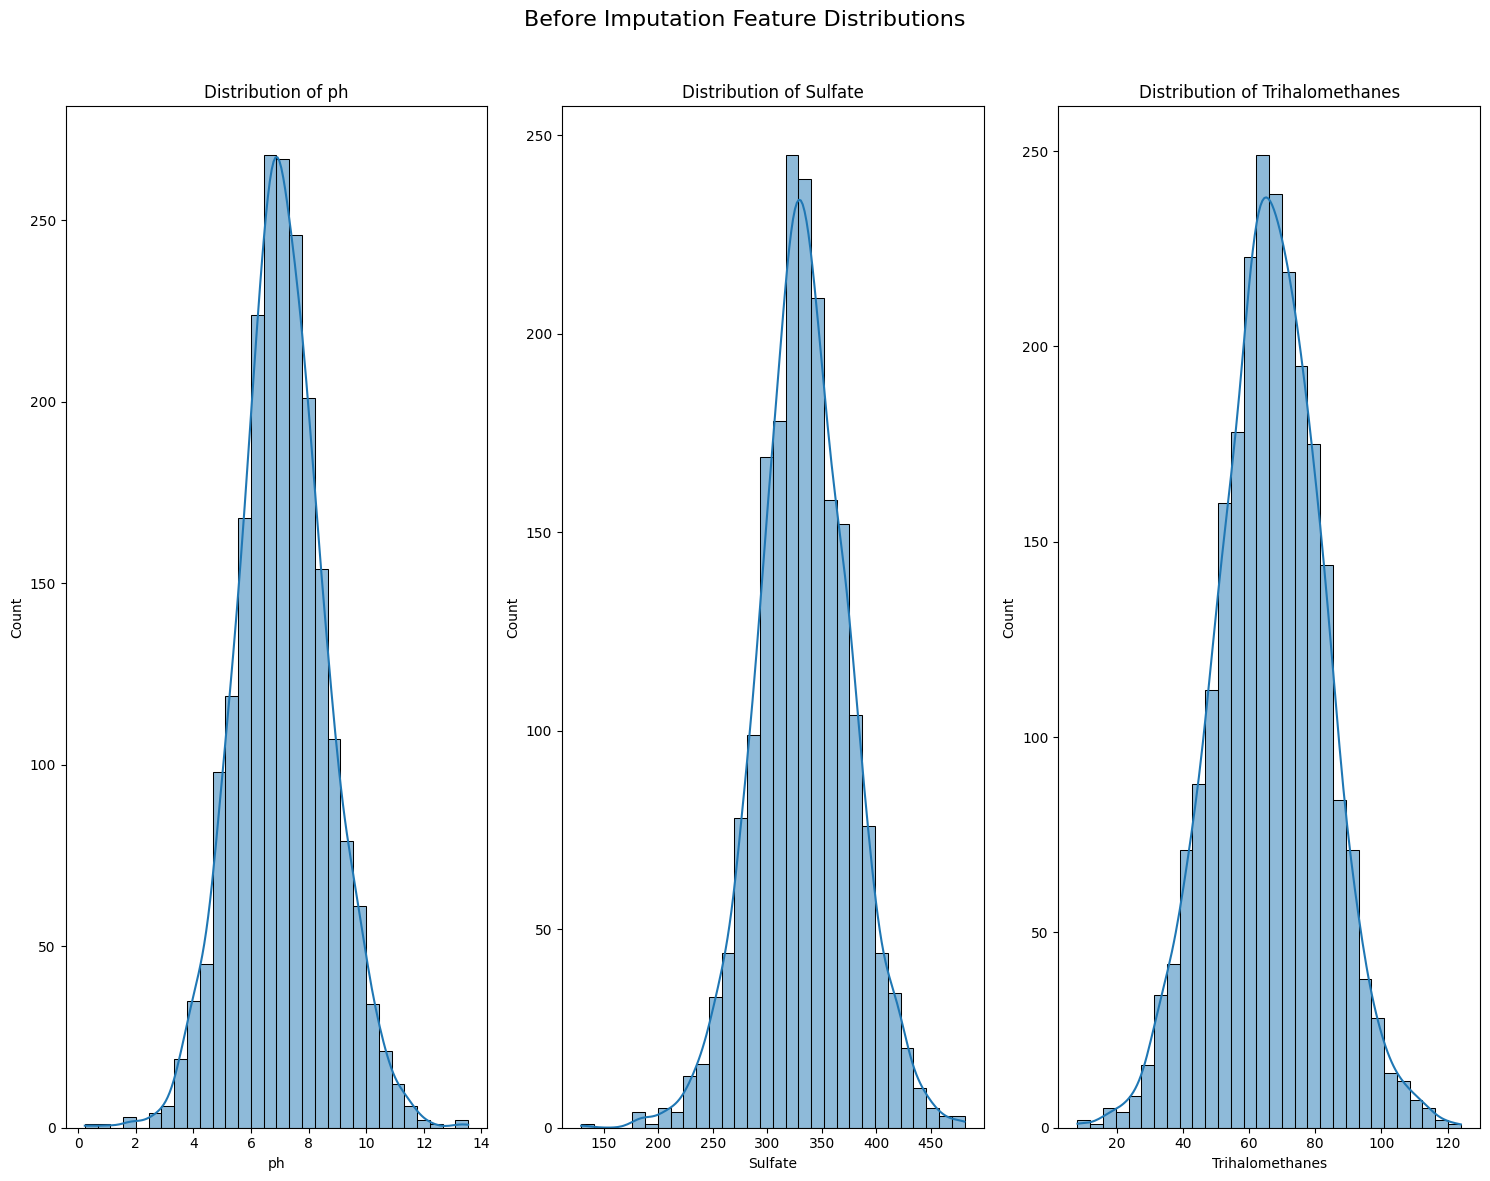


Missing values after imputation: 0


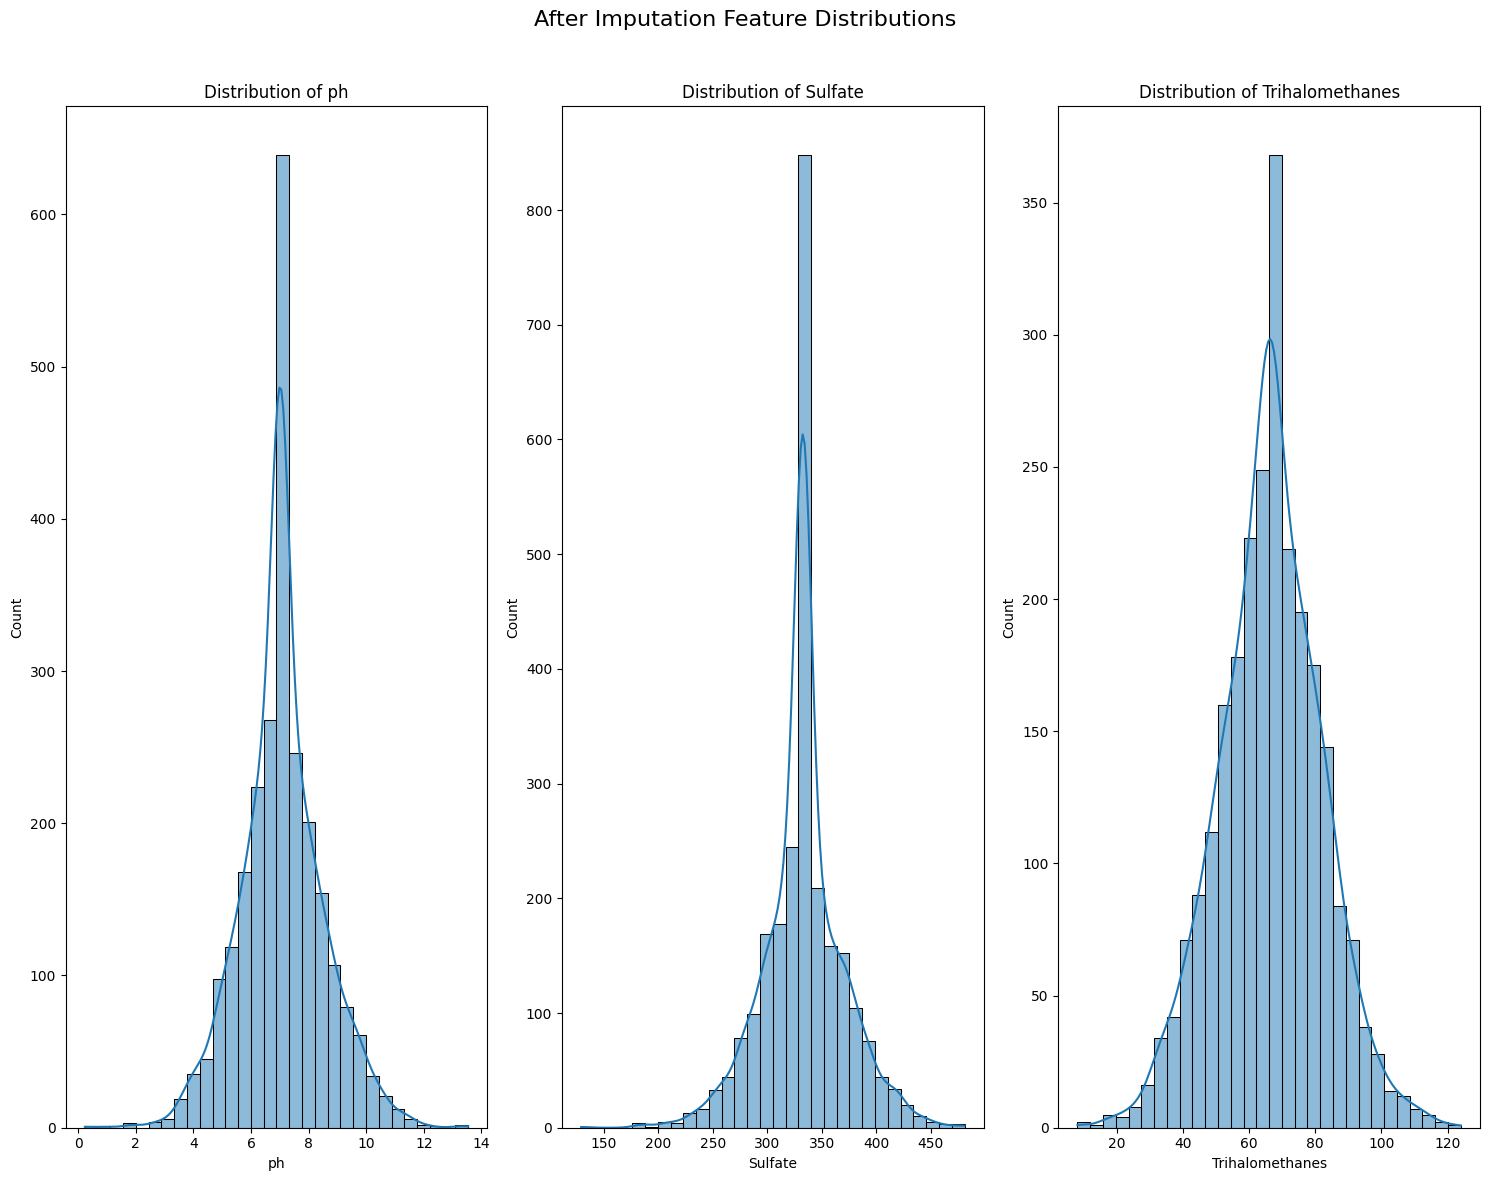

In [4]:
# --------------------------------------------------------------------------
# Technique 1 (Member 1): Handling Missing Data (Imputation)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 1: Missing Value Imputation ---")
missing_percent = (df_eda.isnull().sum() / len(df_eda)) * 100
print(f"Missing values (%):\n{missing_percent[missing_percent > 0]}")

columns_with_missing = df_eda.columns[df_eda.isnull().any()].tolist()
plot_distributions(df_eda, columns_with_missing, 'Before Imputation', os.path.join(RESULTS_DIR, "1_dist_before_imputation.png"))

# Apply Median Imputation
imputer = SimpleImputer(strategy='median')
df_eda[ORIGINAL_FEATURES] = imputer.fit_transform(df_eda[ORIGINAL_FEATURES])

print("\nMissing values after imputation:", df_eda.isnull().sum().sum())
plot_distributions(df_eda, columns_with_missing, 'After Imputation', os.path.join(RESULTS_DIR, "1_dist_after_imputation.png"))


--- EDA for Technique 2: Outlier Handling ---


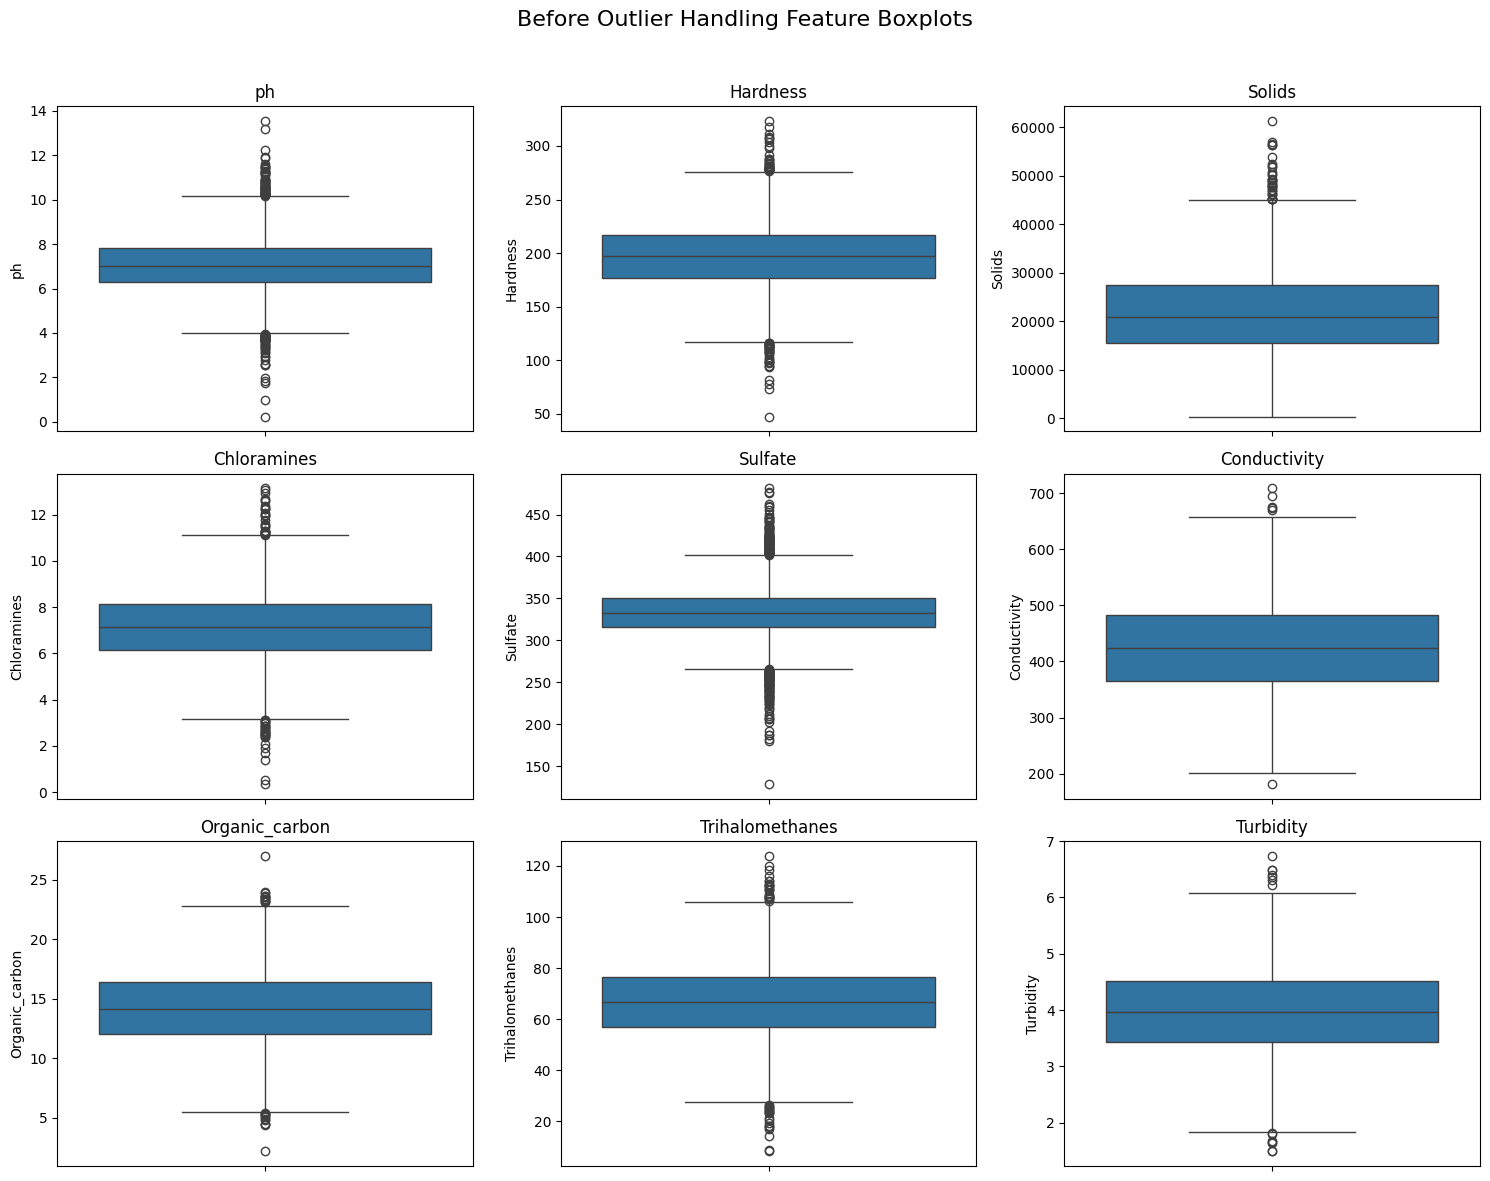

Applied 5%/95% Winsorization to cap outliers.


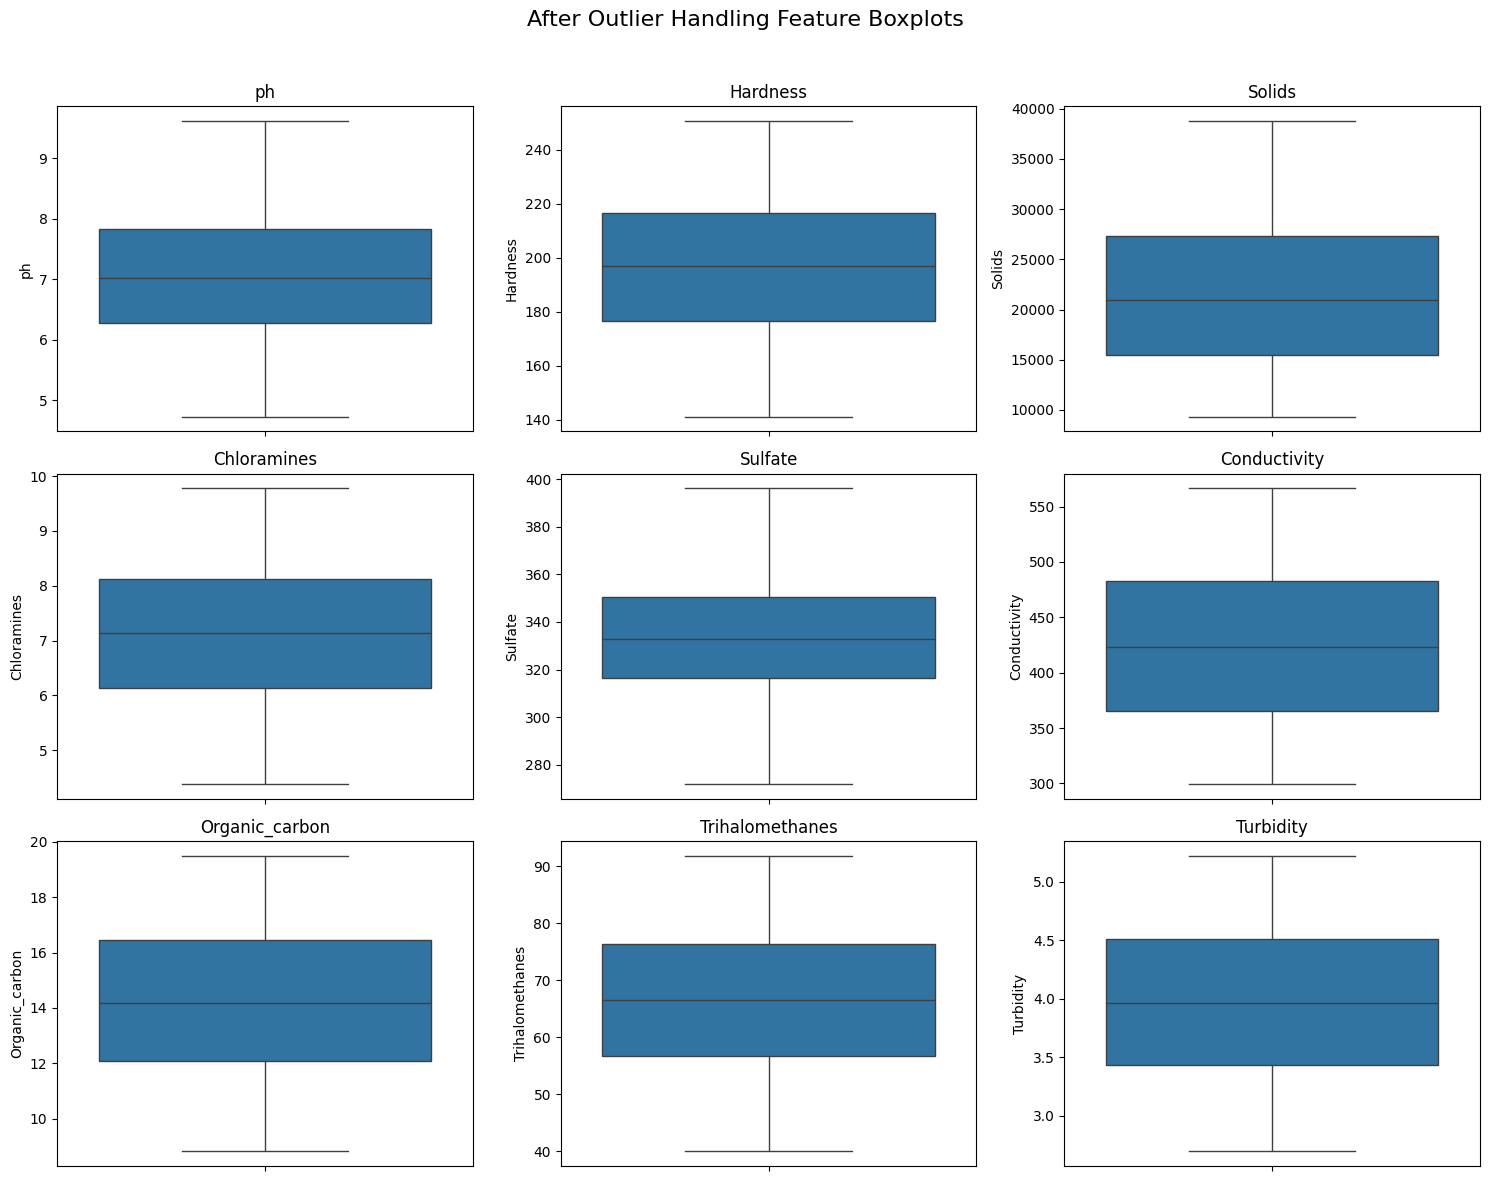

In [5]:
# --------------------------------------------------------------------------
# Technique 2 (Member 2): Outlier Detection and Handling (Winsorization)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 2: Outlier Handling ---")
plot_boxplots(df_eda, ORIGINAL_FEATURES, 'Before Outlier Handling', os.path.join(RESULTS_DIR, "2_boxplots_before_outliers.png"))

# Define custom transformer for pipeline compatibility
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_winsorized = np.copy(X)
        if isinstance(X, pd.DataFrame):
            X_winsorized = X.values.copy()

        for i in range(X_winsorized.shape[1]):
            X_winsorized[:, i] = winsorize(X_winsorized[:, i], limits=self.limits)

        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X_winsorized, columns=X.columns)
        return X_winsorized

# Apply Winsorization for EDA
winsorizer = Winsorizer(limits=[0.05, 0.05])
df_eda[ORIGINAL_FEATURES] = winsorizer.fit_transform(df_eda[ORIGINAL_FEATURES])

print("Applied 5%/95% Winsorization to cap outliers.")
plot_boxplots(df_eda, ORIGINAL_FEATURES, 'After Outlier Handling', os.path.join(RESULTS_DIR, "2_boxplots_after_outliers.png"))



--- EDA for Technique 3: Feature Engineering ---
Created new features: ['ph_hardness', 'chloramines_sulfate_ratio']


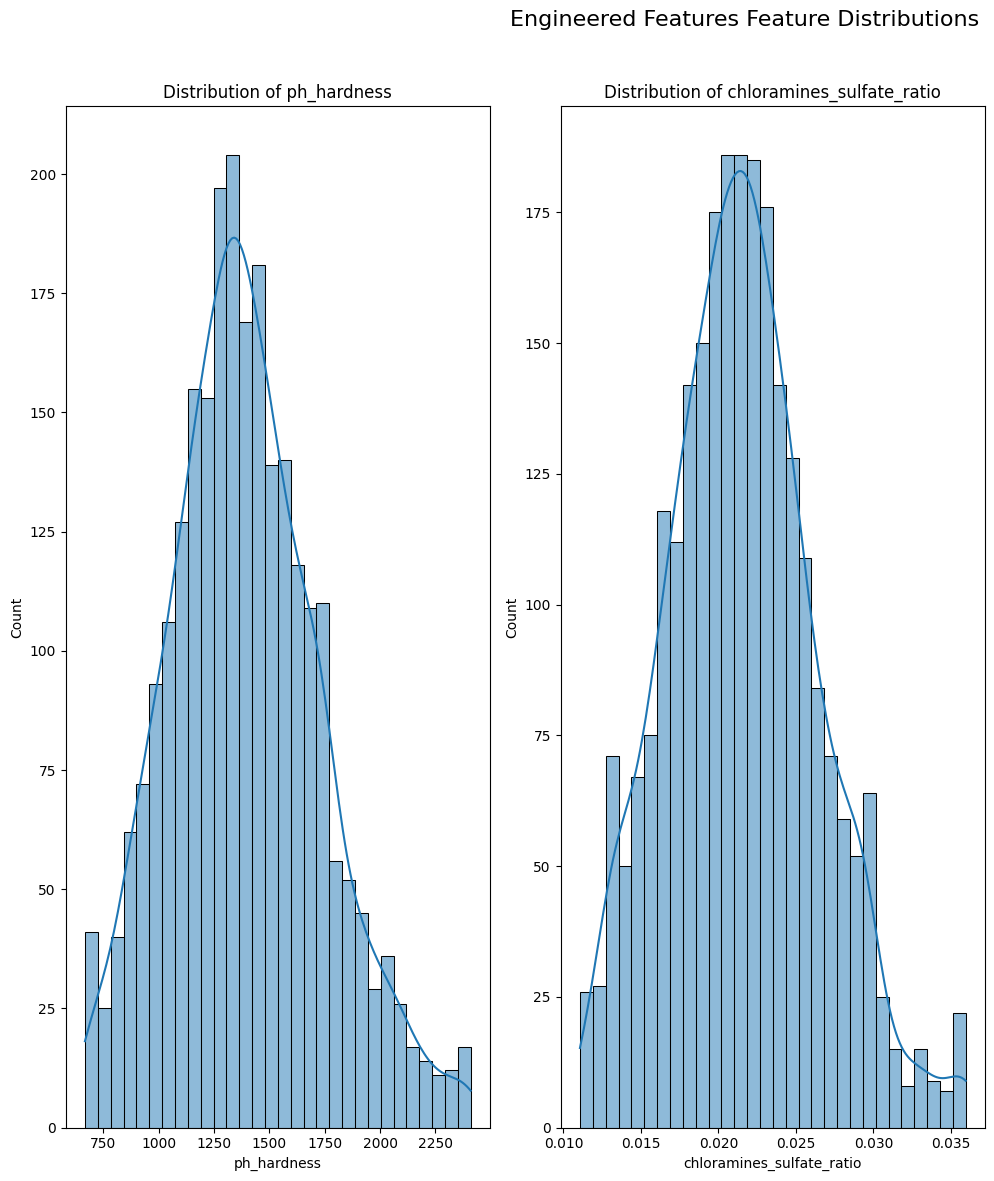

In [6]:
# --------------------------------------------------------------------------
# Technique 3 (Member 3): Feature Engineering
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 3: Feature Engineering ---")

# Define feature engineering function for pipeline compatibility
def _engineer_features(X_in):
    # If X is a DataFrame (e.g., in EDA)
    if isinstance(X_in, pd.DataFrame):
        df = X_in.copy()
    # If X is a numpy array (e.g., in pipeline)
    else:
        df = pd.DataFrame(X_in, columns=ORIGINAL_FEATURES)

    df['ph_hardness'] = df['ph'] * df['Hardness']
    df['chloramines_sulfate_ratio'] = df['Chloramines'] / (df['Sulfate'] + 1e-6)
    return df

# Apply Feature Engineering for EDA
df_eda = _engineer_features(df_eda)
engineered_features = ['ph_hardness', 'chloramines_sulfate_ratio']
all_features = ORIGINAL_FEATURES + engineered_features
print(f"Created new features: {engineered_features}")

plot_distributions(df_eda, engineered_features, 'Engineered Features', os.path.join(RESULTS_DIR, "3_engineered_features.png"))


--- EDA for Technique 4: Data Normalization ---


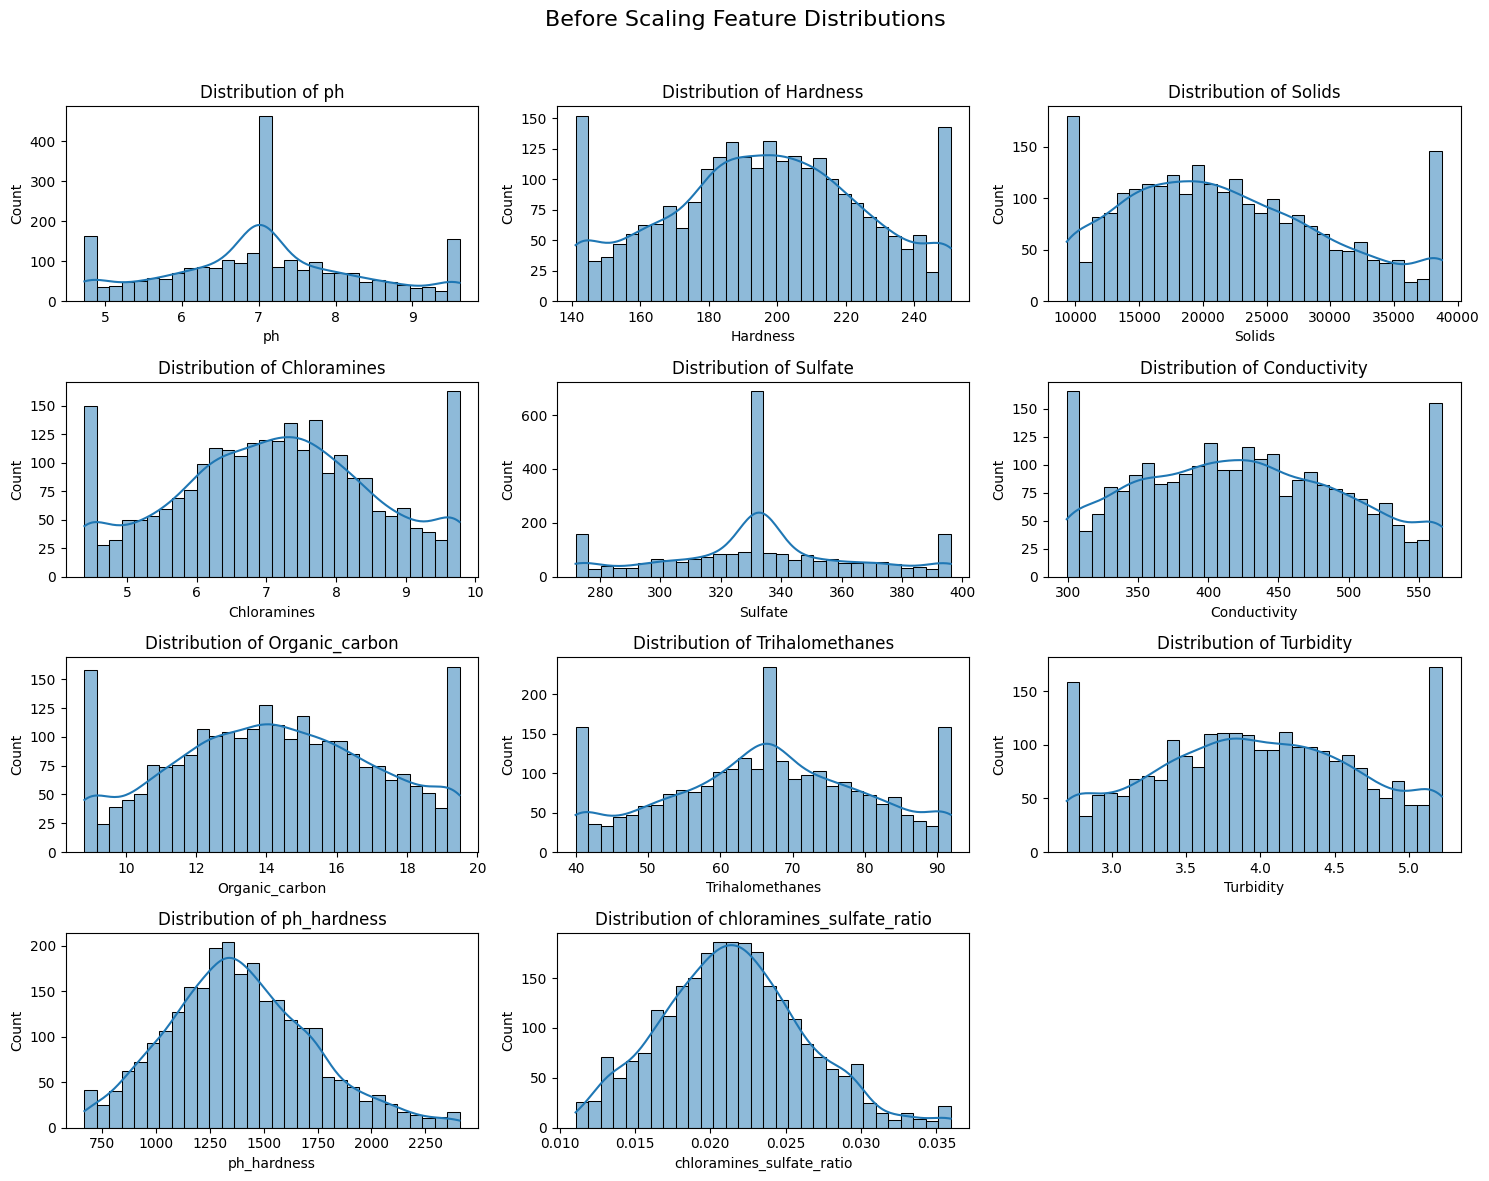

Applied Min-Max Scaling to range [0, 1].


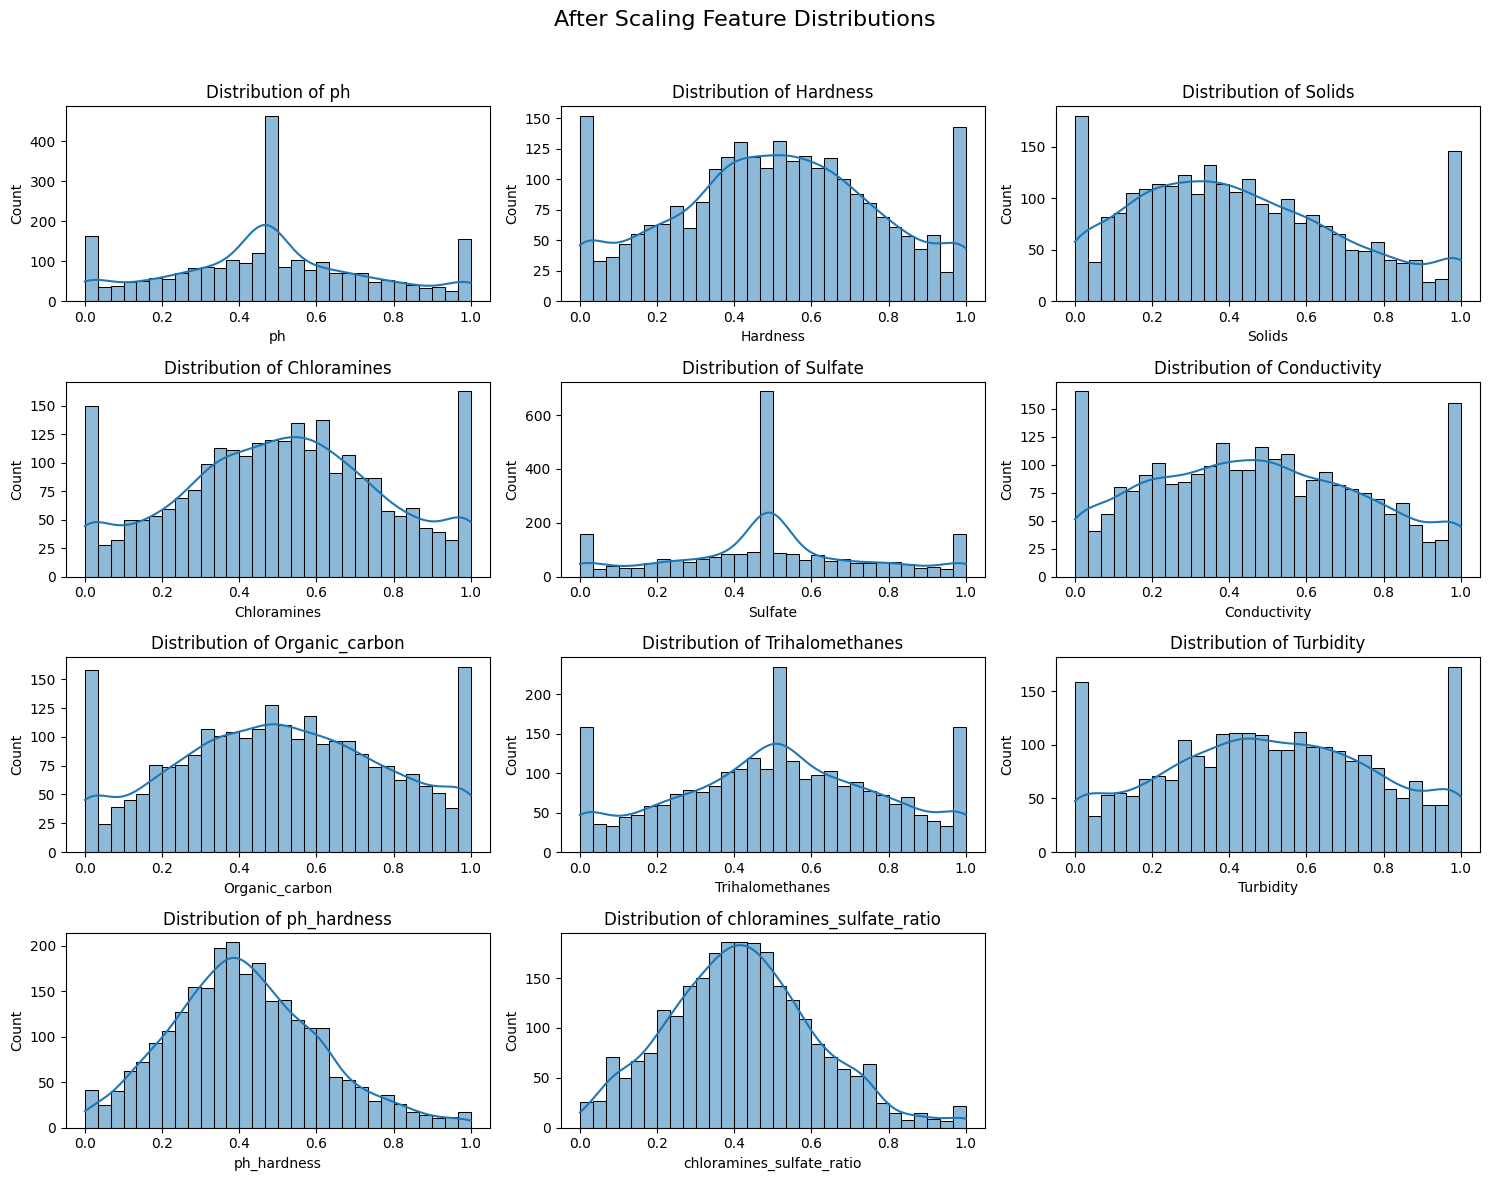

In [7]:
# --------------------------------------------------------------------------
# Technique 4 (Member 4): Data Normalization (Min-Max Scaling)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 4: Data Normalization ---")
plot_distributions(df_eda, all_features, 'Before Scaling', os.path.join(RESULTS_DIR, "4_dist_before_scaling.png"))

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df_eda[all_features] = scaler.fit_transform(df_eda[all_features])

print("Applied Min-Max Scaling to range [0, 1].")
plot_distributions(df_eda, all_features, 'After Scaling', os.path.join(RESULTS_DIR, "4_dist_after_scaling.png"))


--- EDA for Technique 5: Feature Selection ---
Top 8 features identified by f_classif:
| Feature                   |     Score |
|:--------------------------|----------:|
| Solids                    | 3.92733   |
| chloramines_sulfate_ratio | 3.22637   |
| Chloramines               | 2.06647   |
| ph_hardness               | 1.26686   |
| Conductivity              | 0.717278  |
| Organic_carbon            | 0.678994  |
| Hardness                  | 0.451979  |
| Trihalomethanes           | 0.30568   |
| Sulfate                   | 0.291078  |
| Turbidity                 | 0.0791459 |
| ph                        | 0.0658437 |


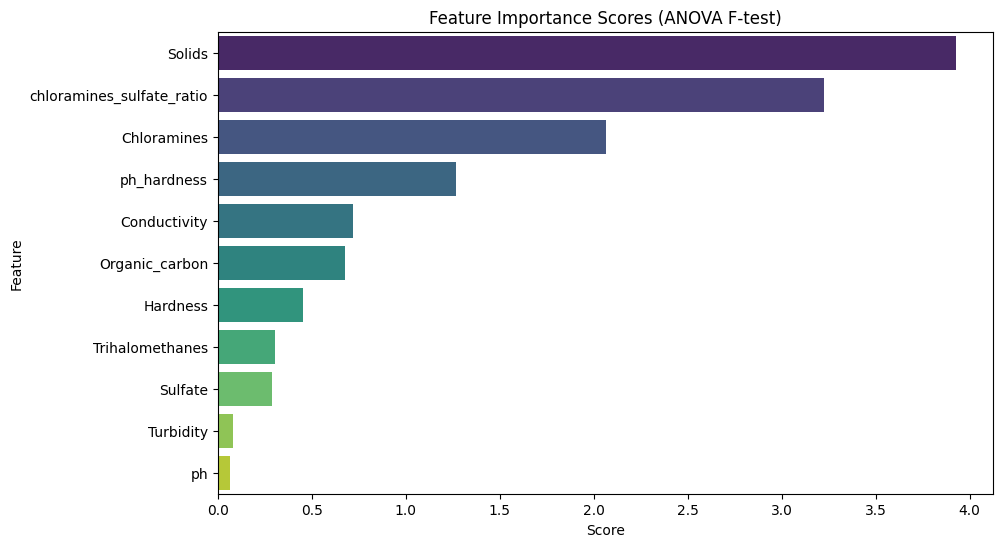

In [8]:
# --------------------------------------------------------------------------
# Technique 5 (Member 5): Feature Selection (ANOVA F-test)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 5: Feature Selection ---")
K_FEATURES = 8
X_eda_scaled = df_eda[all_features]
y_eda = df_eda[TARGET_COLUMN]

selector_eda = SelectKBest(score_func=f_classif, k=K_FEATURES)
selector_eda.fit(X_eda_scaled, y_eda)

# Get scores and feature names
scores = pd.DataFrame({'Feature': all_features, 'Score': selector_eda.scores_})
scores = scores.sort_values(by='Score', ascending=False)
selected_features = scores.head(K_FEATURES)['Feature'].tolist()

print(f"Top {K_FEATURES} features identified by f_classif:")
print(scores.to_markdown(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=scores, palette='viridis')
plt.title('Feature Importance Scores (ANOVA F-test)')
plt.savefig(os.path.join(RESULTS_DIR, "5_feature_importance.png"))
plt.show()


--- EDA for Technique 6: Principal Component Analysis (PCA) ---
Components needed for 95.0% variance: 6


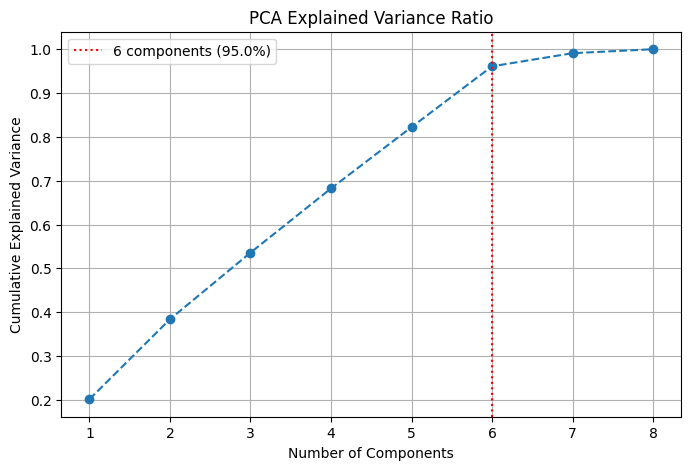

In [9]:
# --------------------------------------------------------------------------
# Technique 6 (Member 6): Dimensionality Reduction (PCA)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 6: Principal Component Analysis (PCA) ---")
# Apply PCA to the selected features
X_eda_selected = df_eda[selected_features]
pca_eda = PCA().fit(X_eda_selected)
cumulative_variance = np.cumsum(pca_eda.explained_variance_ratio_)

# Find components for 95% variance
PCA_VARIANCE_THRESHOLD = 0.95
n_components = np.argmax(cumulative_variance >= PCA_VARIANCE_THRESHOLD) + 1
print(f"Components needed for {PCA_VARIANCE_THRESHOLD*100}% variance: {n_components}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components ({PCA_VARIANCE_THRESHOLD*100}%)')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "6_pca_explained_variance.png"))
plt.show()


--- EDA for Technique 7: Class Imbalance Handling ---
Shape before SMOTE: (2556, 6)
Shape after SMOTE: (2556, 6)


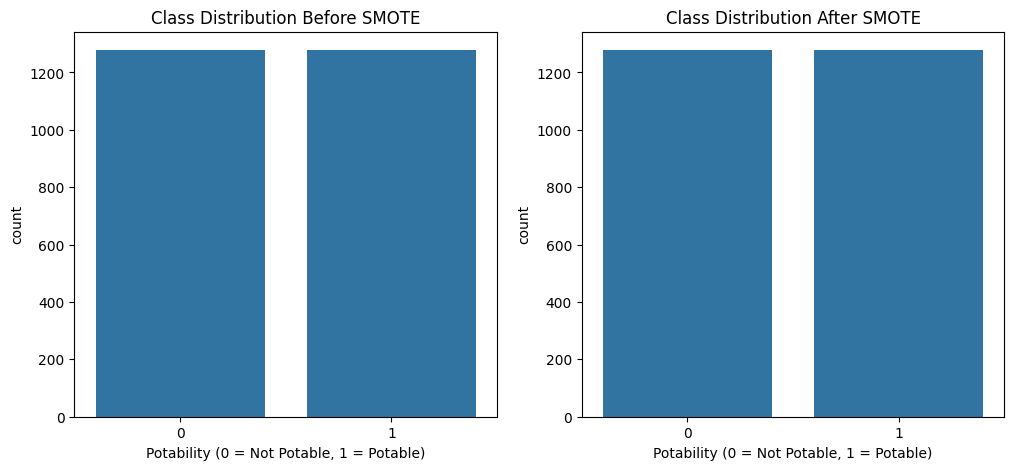


✅ EDA for all 7 preprocessing techniques complete.


In [10]:
# --------------------------------------------------------------------------
# Technique 7 (Member 7): Handling Class Imbalance (SMOTE)
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 7: Class Imbalance Handling ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=TARGET_COLUMN, data=df_eda)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Potability (0 = Not Potable, 1 = Potable)")

# Apply SMOTE
# We apply SMOTE only to the final features (post-PCA)
pca = PCA(n_components=n_components)
X_eda_pca = pca.fit_transform(X_eda_selected)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_eda_pca, y_eda)

print(f"Shape before SMOTE: {X_eda_pca.shape}")
print(f"Shape after SMOTE: {X_resampled.shape}")

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Potability (0 = Not Potable, 1 = Potable)")
plt.savefig(os.path.join(RESULTS_DIR, "7_class_distribution_smote.png"))
plt.show()

print("\n✅ EDA for all 7 preprocessing techniques complete.")

In [11]:
# --- 4. TASK 2: ALGORITHM SELECTION, IMPLEMENTATION & HYPERPARAMETER TUNING ---

"""
### Task 2.1: Algorithm Selection

For this tabular, binary classification task, we will compare several powerful and well-regarded algorithms.

* **Why a Pipeline?** We will embed our entire preprocessing chain (Imputation, Winsorizing, Engineering, Scaling, PCA, SMOTE) into an `ImbPipeline`. This is **critical** to prevent data leakage. The pipeline ensures that steps like imputation and scaling are "fit" *only* on the training data during cross-validation, and then "transformed" on the validation/test data. It also ensures that SMOTE is *only* applied to the training folds.

* **Candidate Algorithms:**
    1.  **Logistic Regression:** A fast, interpretable, and solid baseline model.
    2.  **Random Forest:** An ensemble of decision trees. Excellent performance, robust to outliers (though we've handled them), and good at capturing non-linear relationships.
    3.  **Gradient Boosting (GradientBoostingClassifier):** Another tree-based ensemble that builds trees sequentially. Often achieves state-of-the-art performance on tabular data.

### Task 2.2: Model Implementation (Splitting Data & Defining Pipelines)
"""
# --- Split the *RAW* data ---
# The pipeline will handle all preprocessing internally
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n--- Splitting Raw Data ---")
print(f"Raw Training set shape: {X_train.shape}")
print(f"Raw Test set shape: {X_test.shape}")

# --- Define Re-usable Preprocessing Steps ---
# We use FunctionTransformer to wrap our custom functions
feature_engineer_transformer = FunctionTransformer(_engineer_features)

# This pipeline part contains all steps *before* SMOTE and the model
preprocessing_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('winsorizer', Winsorizer(limits=[0.05, 0.05])),
    ('feature_engineer', feature_engineer_transformer),
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectKBest(score_func=f_classif, k=K_FEATURES)),
    ('pca', PCA(n_components=PCA_VARIANCE_THRESHOLD)) # Uses 95% variance
]

# --- Create Full Pipelines for Each Model ---
pipeline_lr = ImbPipeline(steps=preprocessing_steps + [
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_rf = ImbPipeline(steps=preprocessing_steps + [
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_gb = ImbPipeline(steps=preprocessing_steps + [
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier(random_state=42))
])

print("\n✅ Pipelines defined for Logistic Regression, Random Forest, and Gradient Boosting.")












--- Splitting Raw Data ---
Raw Training set shape: (2044, 9)
Raw Test set shape: (512, 9)

✅ Pipelines defined for Logistic Regression, Random Forest, and Gradient Boosting.


In [12]:


### Task 2.3: Hyperparameter Tuning Strategy

"""We will use **GridSearchCV** with 5-fold cross-validation (`cv=5`) to find the best hyperparameters for each of our three candidate models.

* **GridSearchCV:** This method exhaustively tries all combinations of hyperparameters we define and, using cross-validation, determines which combination performs best on average.
* **Scoring Metric:** We will optimize for the **'f1_macro'** score. In a classification problem, especially one that was initially imbalanced, F1-score provides a better measure of performance than accuracy, as it balances precision and recall.
* **Parameters (Model-Specific):**
    * `model__C` (Logistic Regression): Controls the inverse of regularization strength.
    * `model__n_estimators` (RF & GB): The number of trees in the forest.
    * `model__max_depth` (RF & GB): The maximum depth of each tree.
"""
print("\n--- Training Phase: Hyperparameter Tuning (GridSearchCV) ---")

# --- Define Parameter Grids ---
# Use '__' to access parameters of a step in the pipeline
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__solver': ['liblinear']
}

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5]
}

param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5]
}


--- Training Phase: Hyperparameter Tuning (GridSearchCV) ---


In [13]:
# --- Run Grid Search for Each Model ---
models_to_tune = [
    ('Logistic Regression', pipeline_lr, param_grid_lr),
    ('Random Forest', pipeline_rf, param_grid_rf),
    ('Gradient Boosting', pipeline_gb, param_grid_gb)
]

best_estimators = {}
grid_search_results = []

for name, pipeline, param_grid in models_to_tune:
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_estimators[name] = grid_search.best_estimator_
    result = {
        "Model": name,
        "Best F1-Macro (CV)": grid_search.best_score_,
        "Best Params": grid_search.best_params_
    }
    grid_search_results.append(result)

    print(f"  Best F1-Macro for {name}: {grid_search.best_score_:.4f}")
    print(f"  Best params: {grid_search.best_params_}")


Tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  Best F1-Macro for Logistic Regression: 0.5120
  Best params: {'model__C': 0.1, 'model__solver': 'liblinear'}

Tuning Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  Best F1-Macro for Random Forest: 0.5725
  Best params: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}

Tuning Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  Best F1-Macro for Gradient Boosting: 0.5710
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}



--- Model Comparison Summary (from Cross-Validation) ---
| Model               |   Best F1-Macro (CV) | Best Params                                                                         |
|:--------------------|---------------------:|:------------------------------------------------------------------------------------|
| Random Forest       |               0.5725 | {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100} |
| Gradient Boosting   |               0.5710 | {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}    |
| Logistic Regression |               0.5120 | {'model__C': 0.1, 'model__solver': 'liblinear'}                                     |

--- Final Evaluation of Best Model (Random Forest) on Test Set ---
Test Set Accuracy: 0.6133
Test Set F1-Macro: 0.6133

Classification Report (Test Set):
                 precision    recall  f1-score   support

Not Potable (0)       0.61      0.62      0.61       256
    Pot

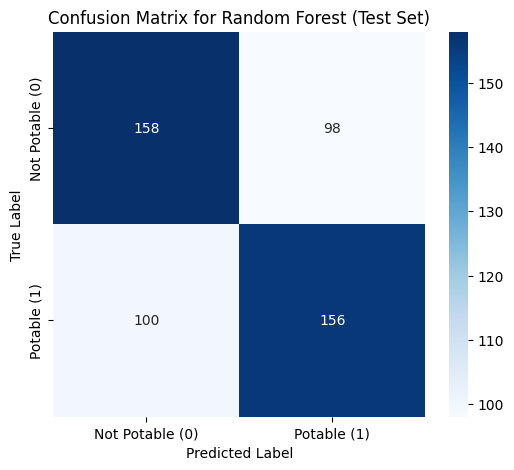

In [14]:
# --- 5. TASK 3: EVALUATION METRICS, CROSS-VALIDATION, MODEL COMPARISON ---

"""
### Task 3.1: Evaluation Metrics

To evaluate our binary classification models, we use several key metrics:

* **Accuracy:** The ratio of correctly predicted samples to the total number of samples. `Accuracy = (TP + TN) / (TP + TN + FP + FN)`.
* **Precision:** Measures the accuracy of positive predictions. `Precision = TP / (TP + FP)`. High precision means that when the model predicts water is "Potable", it is very likely correct.
* **Recall (Sensitivity):** Measures the model's ability to find all positive samples. `Recall = TP / (TP + FN)`. High recall means the model is good at identifying *all* the "Potable" samples.
* **F1-Score:** The harmonic mean of Precision and Recall (`2 * (Precision * Recall) / (Precision + Recall)`). It provides a single score that balances both metrics. We use the **Macro Average F1** (f1_macro), which calculates the F1-score for each class independently and then takes the average, treating both classes (Potable and Not Potable) equally.
* **Confusion Matrix:** A table that visualizes performance, showing correct predictions vs. errors (False Positives and False Negatives).

### Task 3.2: Cross-Validation Approach

We have already implemented a robust cross-validation strategy. **GridSearchCV with `cv=5`** *is* our K-Fold Cross-Validation approach.

During tuning, `GridSearchCV` automatically splits the `X_train`, `y_train` data into 5 folds. For each hyperparameter combination, it trains the *entire pipeline* (including imputation, scaling, SMOTE, etc.) on 4 folds and validates on the 5th fold. This is repeated 5 times, and the F1-scores are averaged. This gives a reliable estimate of how each model configuration will perform on unseen data.

### Task 3.3: Model Comparison
"""
print("\n--- Model Comparison Summary (from Cross-Validation) ---")
results_df = pd.DataFrame(grid_search_results).sort_values(by="Best F1-Macro (CV)", ascending=False)
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# --- Final Evaluation on the Test Set ---
# Select the best model based on its CV score
best_model_name = results_df.iloc[0]["Model"]
final_model = best_estimators[best_model_name]

print(f"\n--- Final Evaluation of Best Model ({best_model_name}) on Test Set ---")
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1] # Probability of class 1

print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Set F1-Macro: {f1_score(y_test, y_pred, average='macro'):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Not Potable (0)', 'Potable (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Potable (0)', 'Potable (1)'],
    yticklabels=['Not Potable (0)', 'Potable (1)']
)
plt.title(f'Confusion Matrix for {best_model_name} (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(RESULTS_DIR, "8_final_confusion_matrix.png"))
plt.show()

In [15]:
# --- 6. TASK 4: ETHICAL AND BIAS ANALYSIS ---
"""
### Task 4.1: Ethical and Bias Analysis

It is crucial to consider the ethical implications and potential biases of this model.

* **Dataset Bias:**
    * **Source Bias:** The "Kavi-ya/Water-Potability" dataset's origin is not fully specified. It may come from a specific geographic region, or only from municipal water sources, or only from lab samples.
    * **Impact:** If the data is not diverse (e.g., lacks well water, river water, or water from different countries), the model will perform poorly on such samples. It has learned a very narrow definition of "potable."
    * **Imbalance:** The original dataset was imbalanced (~61% Not Potable, 39% Potable). While we corrected this with SMOTE, it's important to know *why* it was imbalanced. Does it reflect the real world, or just a data collection quirk?

* **Potential for Misuse & Societal Impact:**
    * **CRITICAL RISK:** This is the most significant ethical concern. A user might test their water, receive a "Safe" prediction (a **False Negative** if the water is actually unsafe), and consume contaminated water, leading to serious illness or death.
    * **False Security:** The model only tests for the 9 parameters it was trained on. Water can be "unsafe" due to biological contaminants (bacteria, viruses), heavy metals (lead, arsenic), or other chemicals not included in the model.
    * **Conclusion:** This tool **must not** be deployed as a substitute for professional, certified laboratory testing. It should be marketed strictly as an **educational tool** to help users understand how different chemical parameters *relate* to potability, not as a real-world safety test.

* **Transparency and Fairness:**
    * **"Black Box" Problem:** Ensemble models (Random Forest, Gradient Boosting) are notoriously difficult to interpret. We cannot easily explain *why* a specific sample was flagged as "unsafe."
    * **Mitigation Strategy:** Our frontend application *does* show a confidence score, which is a good step. It communicates uncertainty. We also provide recommendations based on which *input values* (like pH or Turbidity) are outside ideal ranges, which adds a layer of rule-based interpretability on top of the "black box" prediction.
"""

'\n### Task 4.1: Ethical and Bias Analysis\n\nIt is crucial to consider the ethical implications and potential biases of this model.\n\n* **Dataset Bias:**\n    * **Source Bias:** The "Kavi-ya/Water-Potability" dataset\'s origin is not fully specified. It may come from a specific geographic region, or only from municipal water sources, or only from lab samples.\n    * **Impact:** If the data is not diverse (e.g., lacks well water, river water, or water from different countries), the model will perform poorly on such samples. It has learned a very narrow definition of "potable."\n    * **Imbalance:** The original dataset was imbalanced (~61% Not Potable, 39% Potable). While we corrected this with SMOTE, it\'s important to know *why* it was imbalanced. Does it reflect the real world, or just a data collection quirk?\n\n* **Potential for Misuse & Societal Impact:**\n    * **CRITICAL RISK:** This is the most significant ethical concern. A user might test their water, receive a "Safe" predi

In [16]:
# --- 7. SAVE THE FINAL MODEL ---
final_model_path = os.path.join(MODELS_DIR, "water_quality_pipeline.joblib")
joblib.dump(final_model, final_model_path)

print(f"\n✅ Final production-ready model ({best_model_name}) saved as:")
print(f"{final_model_path}")
print("This file contains the complete preprocessing and modeling pipeline.")

print("\n--- ✅ FULL PIPELINE SCRIPT COMPLETE ---")


✅ Final production-ready model (Random Forest) saved as:
/content/models/water_quality_pipeline.joblib
This file contains the complete preprocessing and modeling pipeline.

--- ✅ FULL PIPELINE SCRIPT COMPLETE ---
